<h1> Binance Data Science & Algorithm Internship Take Home Assessment </h1>

<h2> Part 2 Questions </h2>
○	Tell us how you validate your model and why you chose such evaluation technique(s). <br>

     The KNN, RandomForest, GradientBoosting and XGBoost models were evaluated using AUC and cross validation AUC scores. I chose to additionaly validate my models using the CV AUC to check that the model has not overfit our training data.

○	What is AUC? Why do you think AUC was used as the evaluation metric for this challenge? What other metrics do you think would also be suitable for this competition? <br>

     The AUC (Area Under Curve) is the 2-dimensional area underneath a curve. The AUC of the ROC (Receiver Operating Characteristic), which was used as the evaluation metric for this challenge, measures the performance of classification models with various thresholds. The AUC ranges from 0 to 1, where 1 shows perfect prediciton.
     
     The AUC was likely chosen as the metric due to its threshold-invariant and scale-invariant properties. The AUC measures the quality of the model's predictions, independent of what classification threshold was used (unlike F1-scores). This also means that the AUC measures how well the predictions are ranked, rather than their absolute values.
     
     Another metric that could have been used for this competition is the Kolomogorov Smirnov chart to mesasure performance of classification models using degree of separation.

○	Short explanation of what you tried. What worked and what did not work (ie. you might have tried different features/models before the final one). What insight(s) do you have from your model(s)? <br>

     Comparing the AUC scores from the KNN, XGBoost, GradientBoosting and RandomForest models, it was found that the XGBoost and GradientBoosting models showed the highest accuracy for predicting the probability of financial distress in the next 2 years.
     Although GradientBoosting showed a higher AUC than XGBoost, the XGBoost model had a much faster performance time by 1m 15s, or 327%. For larger datasets, XGBoost would be more optimal as a prediction model.
     Since this competition is scored based on AUC, GradientBoosting was be used as the final model.

In [ ]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install -U scikit-learn
!pip install xgboost

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, roc_auc_score
import seaborn as sns


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

<h2> Load and Explore Datasets </h2>

In [24]:
train = pd.read_csv('../data/cs-training.csv')
test = pd.read_csv('../data/cs-test.csv')
train.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [25]:
train.rename(columns={'Unnamed: 0':'ID'}, inplace=True)
test.rename(columns={'Unnamed: 0':'ID'}, inplace=True)

In [26]:
P = train.groupby('SeriousDlqin2yrs')['ID'].count().reset_index()
P['Percentage'] = 100 * P['ID'] / P['ID'].sum()
print(P)

   SeriousDlqin2yrs      ID  Percentage
0                 0  139974      93.316
1                 1   10026       6.684


<h2> Preprocessing </h2>
Age is assumed to be between 18 and 100 for loans. Check outliers and clean the dataset. <br>
When there is a "0" value age, or null value monthly income, these entries will be replaced by the median/ mean value.

In [27]:
train.loc[train['age'] == 0, 'age'] = train['age'].median()
train['MonthlyIncome'] = train['MonthlyIncome'].replace(np.nan,train['MonthlyIncome'].mean())
train['NumberOfDependents'].fillna(train['NumberOfDependents'].median(), inplace=True)

<h3> Check Data Using Confusion Matrix </h3>

<AxesSubplot: >

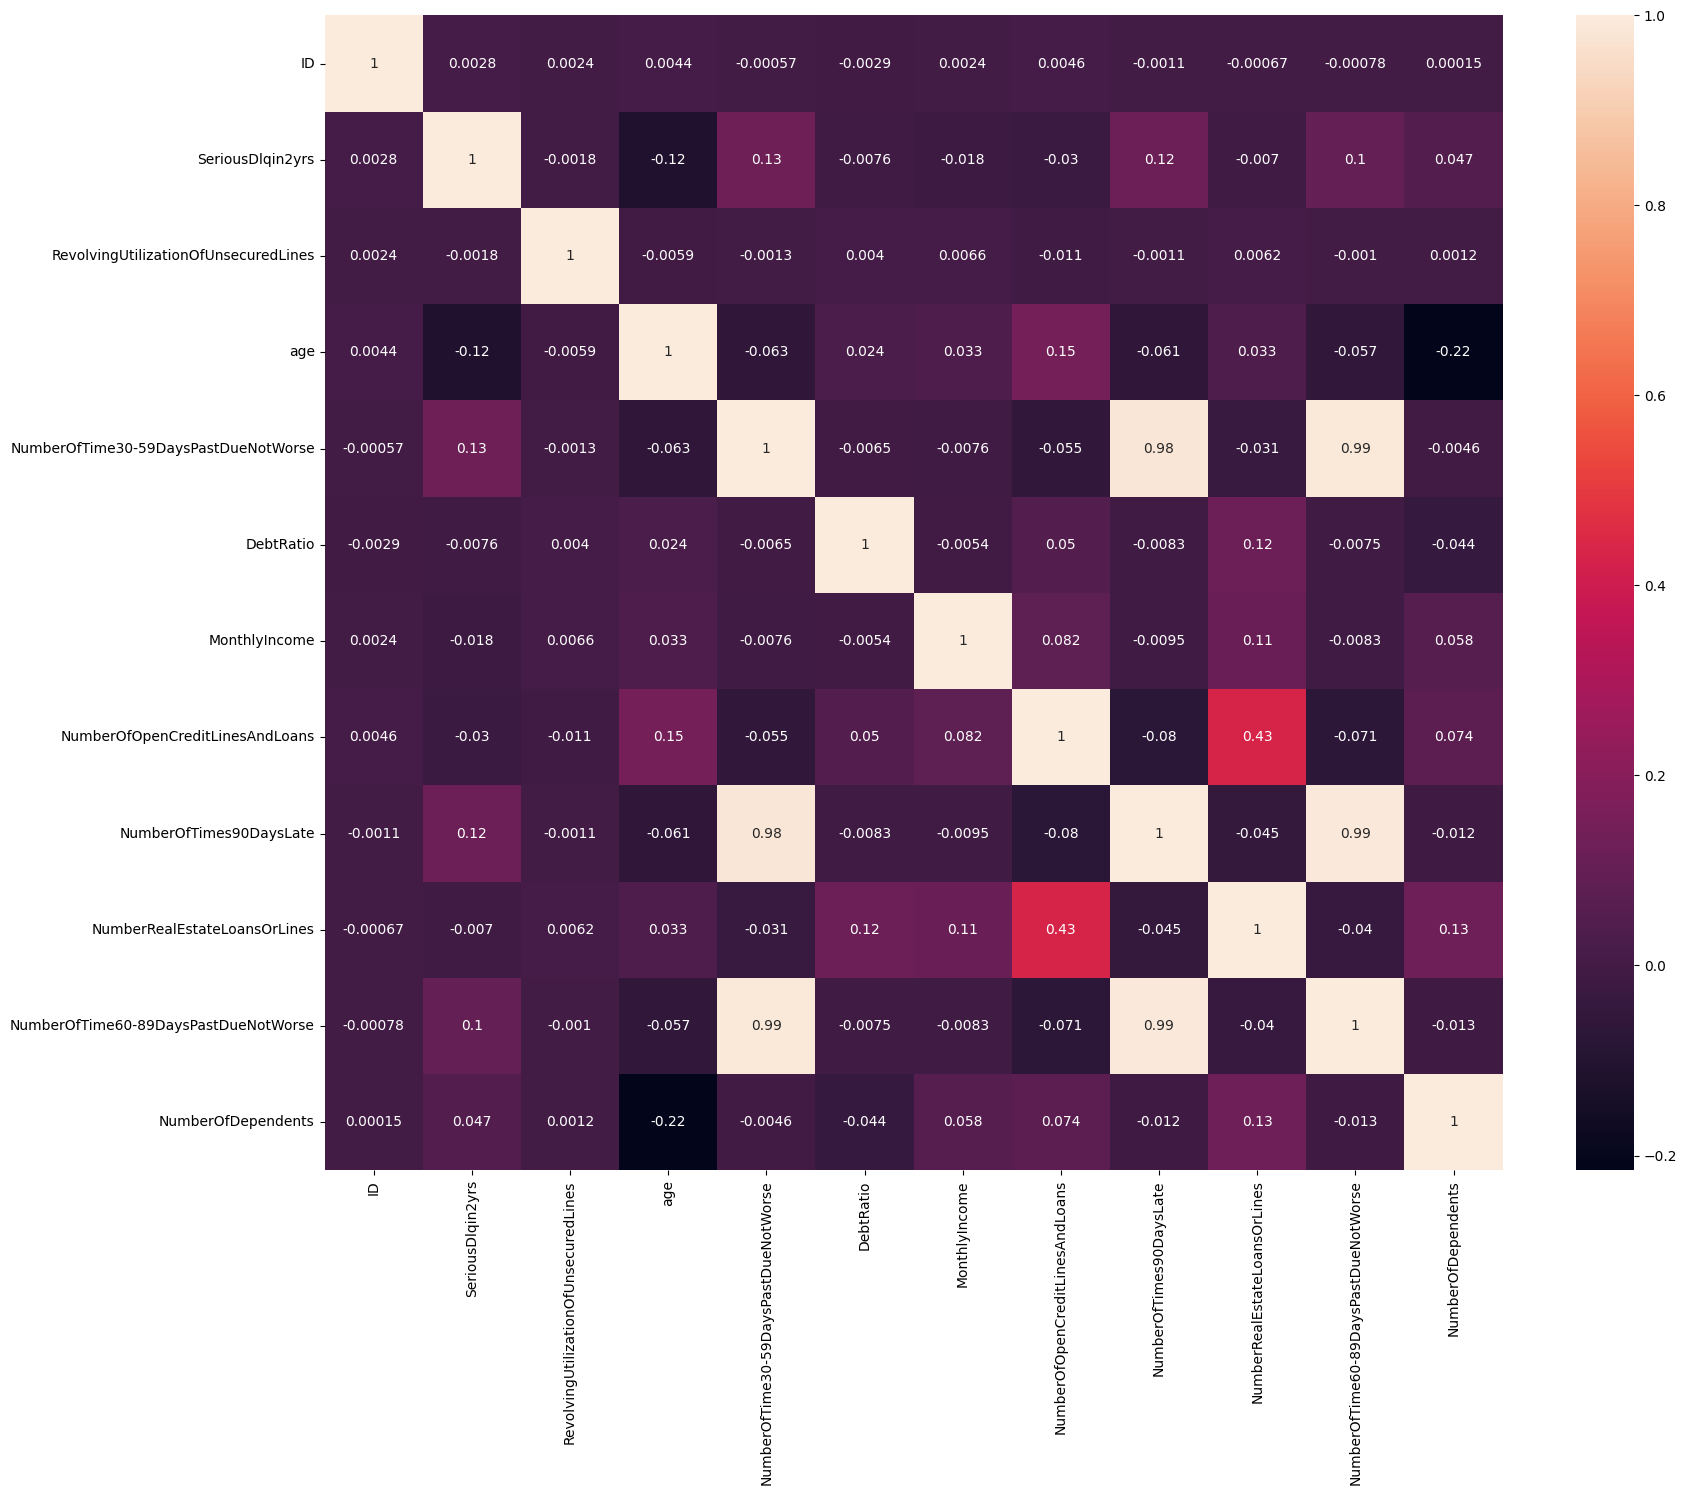

In [28]:
corr = train.corr()
plt.figure(figsize=(19, 15))
sns.heatmap(corr, annot=True)

Here we see that outliers exist in:

- 'NumberOfTime30-59DaysPastDueNotWorse', 
- 'NumberOfTime60-89DaysPastDueNotWorse',
- 'NumberOfTimes90DaysLate'.

Boxplot these features to see where this occurs, then replace outlier values with the median value.

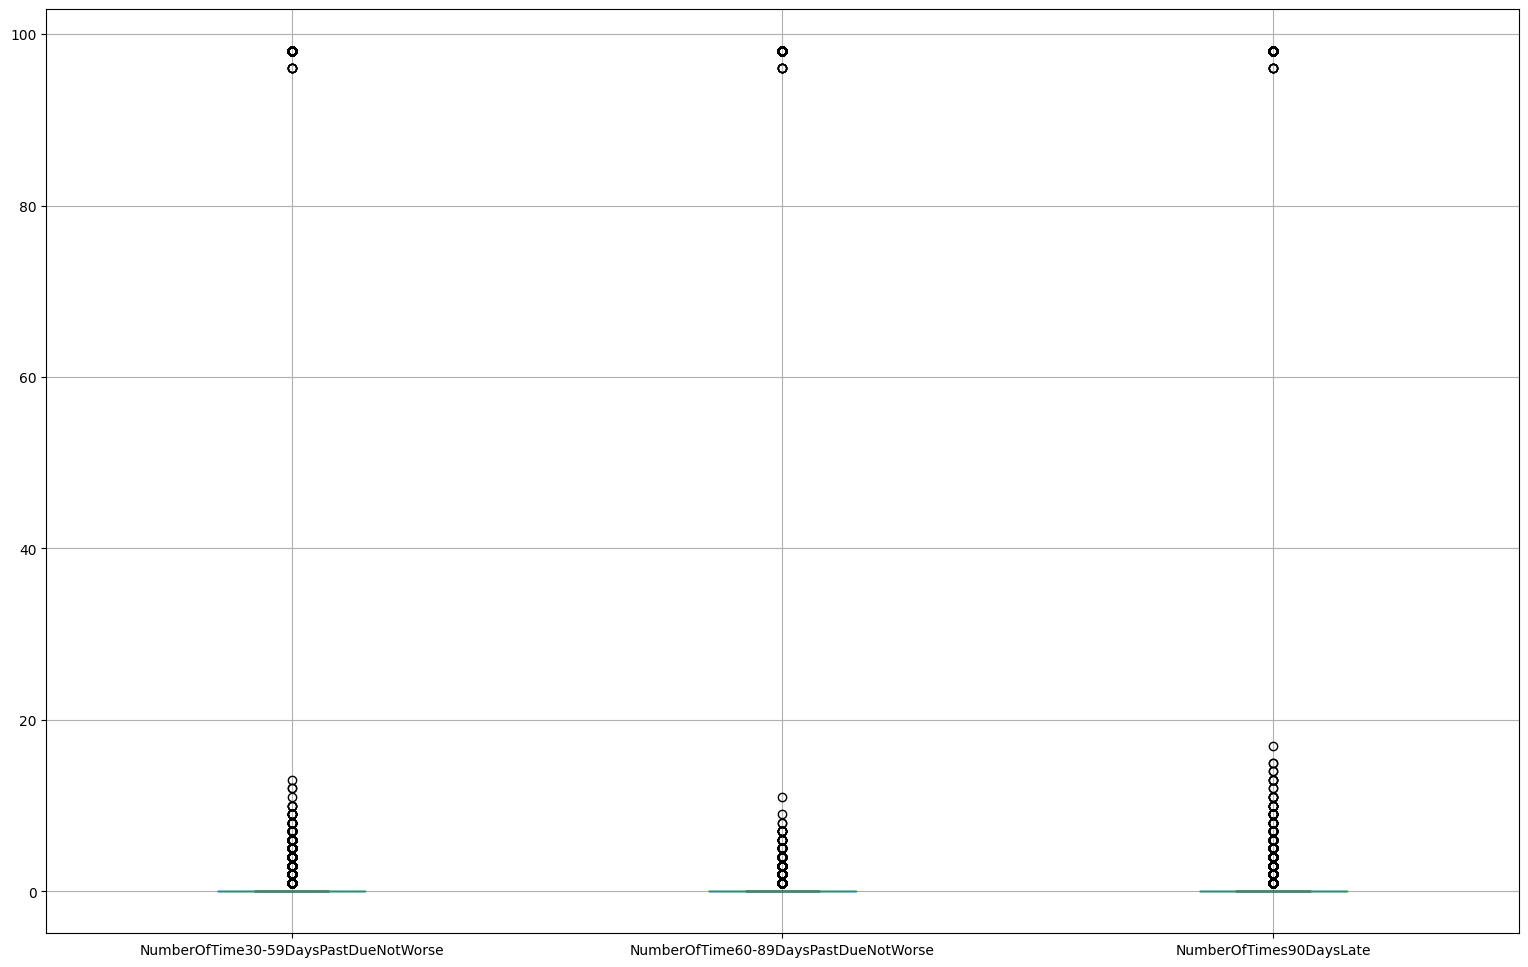

In [29]:
plt.figure(figsize=(19, 12)) 
train[['NumberOfTime30-59DaysPastDueNotWorse', 
          'NumberOfTime60-89DaysPastDueNotWorse',
          'NumberOfTimes90DaysLate']].boxplot()
plt.show()

In [30]:
def replace98and99(column):
    new = []
    newval = column.median()
    for i in column:
        if (i == 98 or i == 99):
            new.append(newval)
        else:
            new.append(i)
    return new

In [31]:
train['NumberOfTime30-59DaysPastDueNotWorse'] = replace98and99(train['NumberOfTime30-59DaysPastDueNotWorse'])
train['NumberOfTimes90DaysLate'] = replace98and99(train['NumberOfTimes90DaysLate'])
train['NumberOfTime60-89DaysPastDueNotWorse'] = replace98and99(train['NumberOfTime60-89DaysPastDueNotWorse'])

test['NumberOfTime30-59DaysPastDueNotWorse'] = replace98and99(test['NumberOfTime30-59DaysPastDueNotWorse'])
test['NumberOfTimes90DaysLate'] = replace98and99(test['NumberOfTimes90DaysLate'])
test['NumberOfTime60-89DaysPastDueNotWorse'] = replace98and99(test['NumberOfTime60-89DaysPastDueNotWorse'])

<AxesSubplot: >

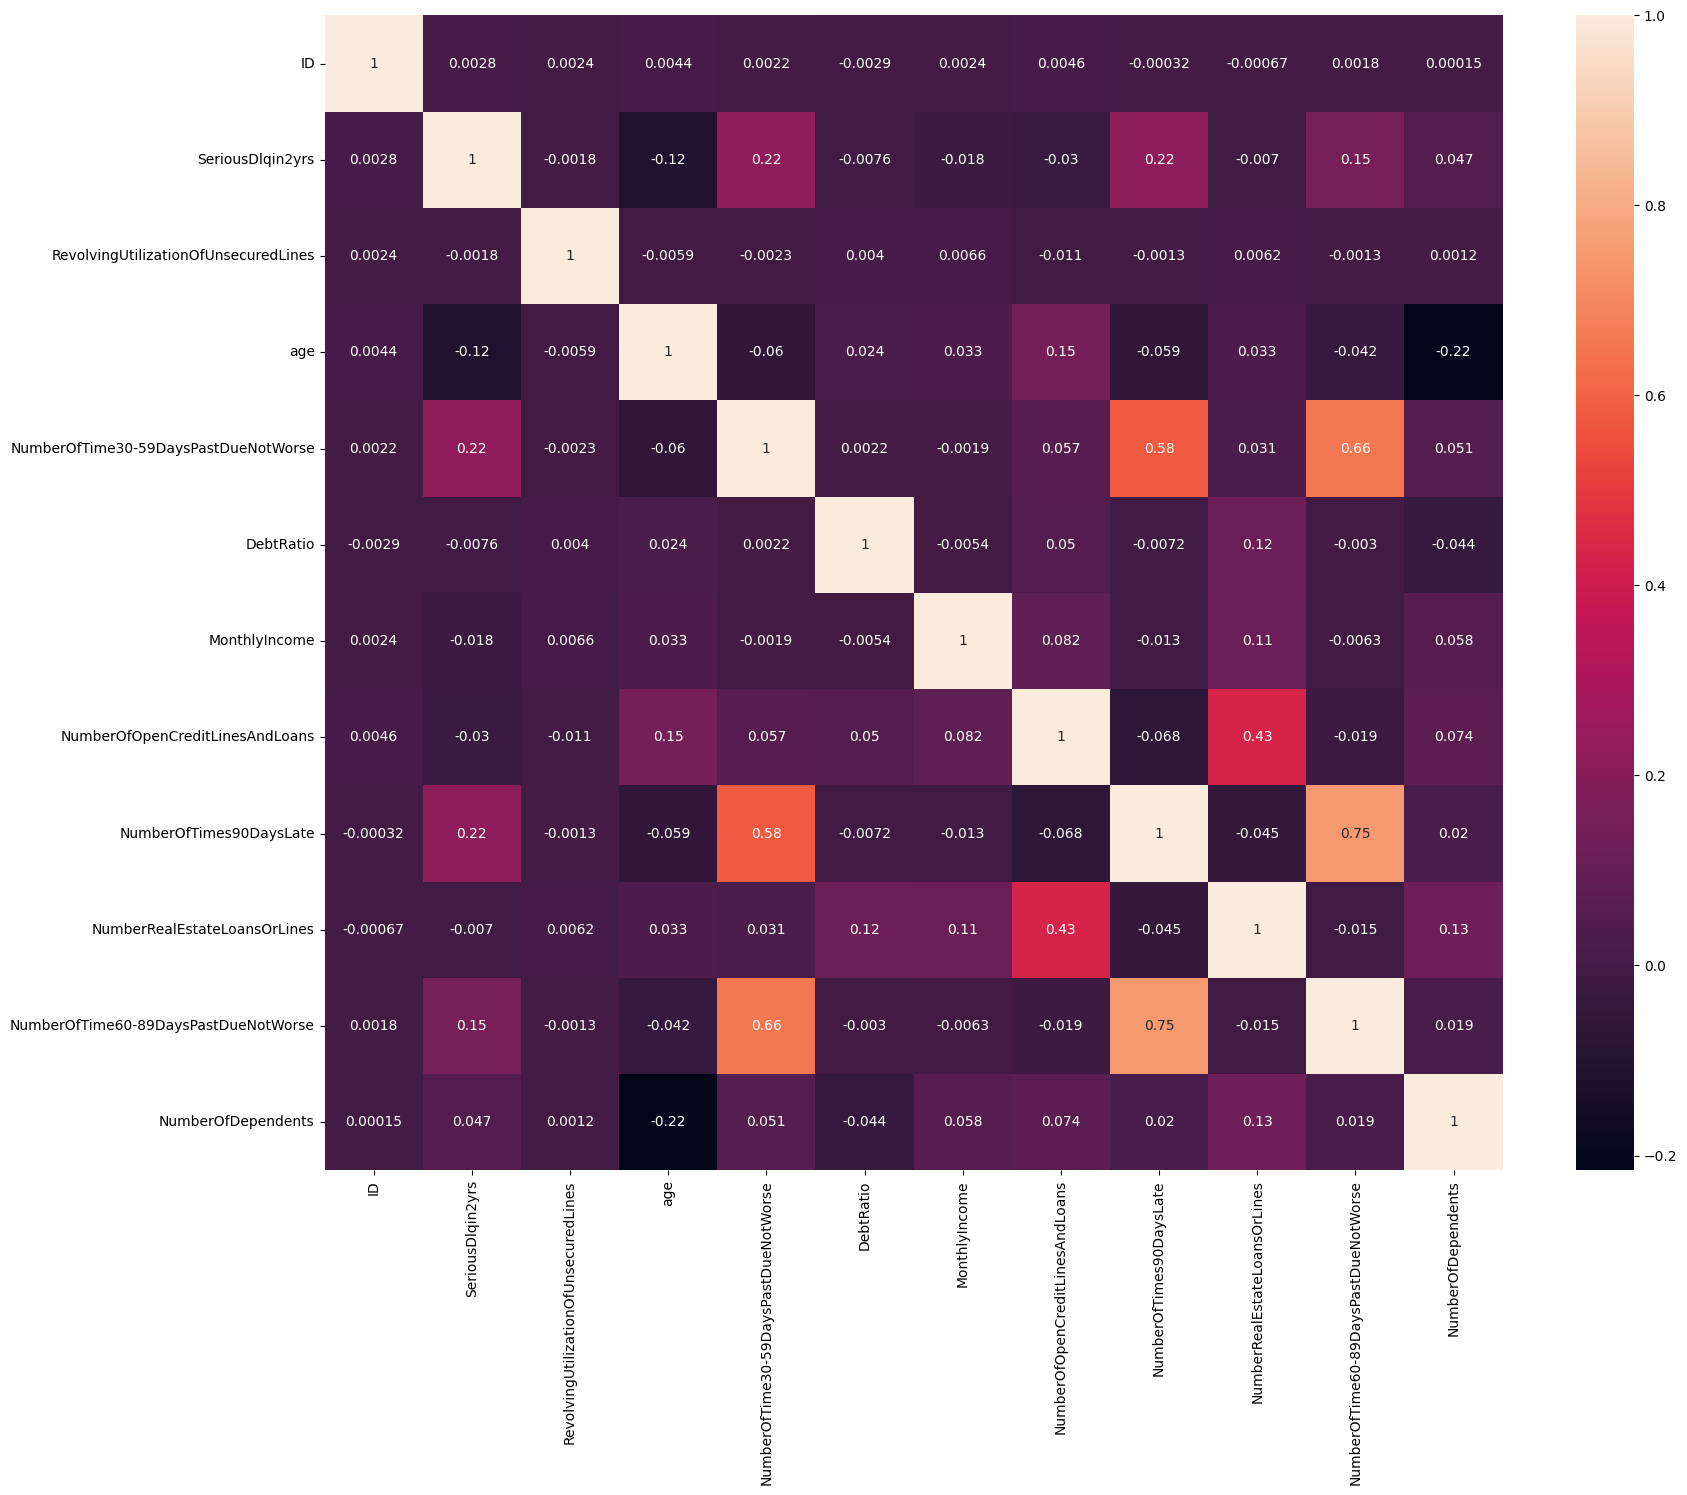

In [32]:
corr = train.corr()
plt.figure(figsize=(19, 15))
sns.heatmap(corr, annot=True)

<h2> Model </h2>

<h3> Extract train / test datasets </h3>

In [33]:
# Will be further split into train/test sets
X = train.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
Y = train['SeriousDlqin2yrs']

# For evaluating our model later
x = test.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
y = test['SeriousDlqin2yrs']

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=111)

<h3> Logistic Regression </h3>

In [34]:
logit = LogisticRegression(random_state=111, solver='saga', penalty='l1', class_weight='balanced', C=1.0, max_iter=500)
scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

logit.fit(X_train_scaled, Y_train)

logit_scores_proba = logit.predict_proba(X_train_scaled)
logit_scores = logit_scores_proba[:,1]

In [35]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(12,10))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive rate")

Train AUC Score :  0.8160770921951955


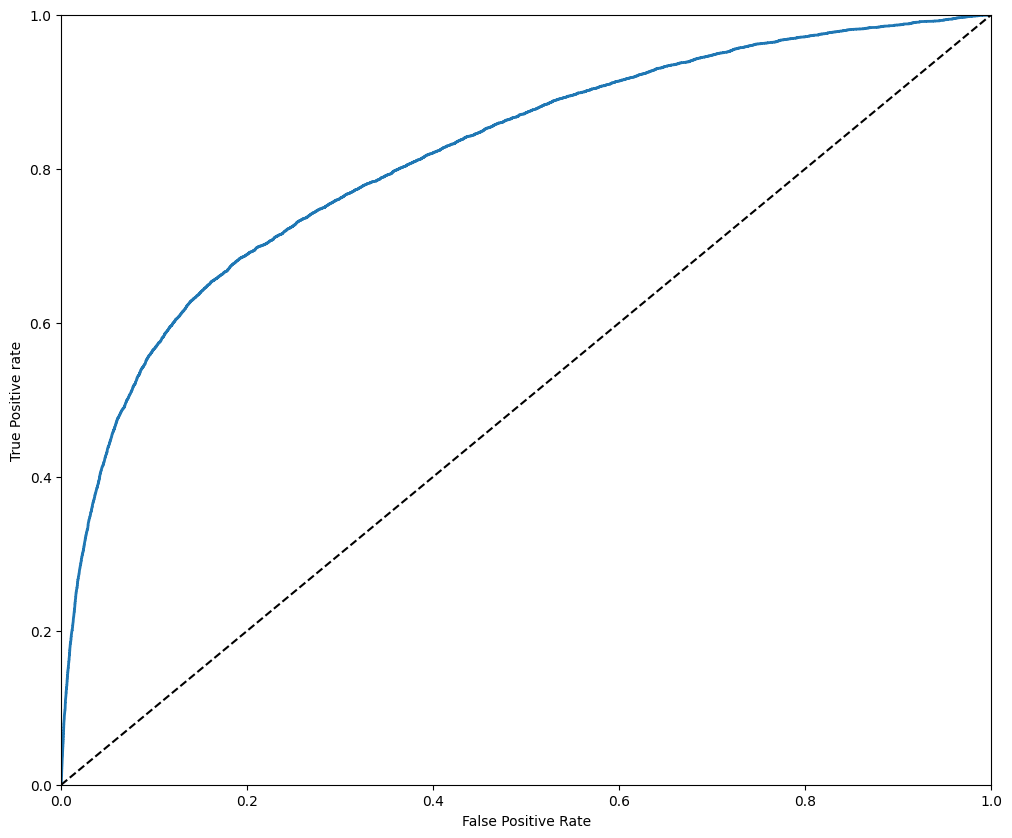

In [38]:
fpr_logit, tpr_logit, thresh_logit = roc_curve(Y_train, logit_scores)

plot_roc_curve(fpr_logit,tpr_logit)
print('Train AUC Score : ', (roc_auc_score(Y_train,logit_scores)))

Test AUC Score : 0.8116669189076563


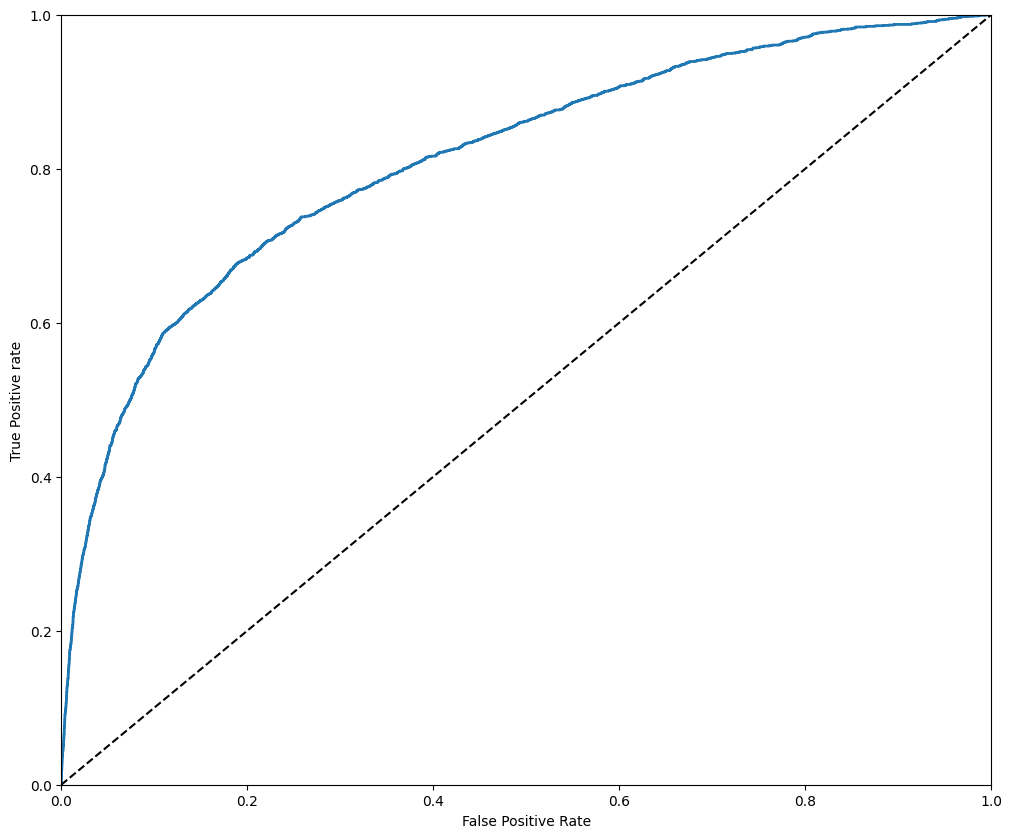

In [39]:
logit_scores_proba_val = logit.predict_proba(X_test_scaled)

logit_scores_val = logit_scores_proba_val[:,1]

fpr_logit_val, tpr_logit_val, thresh_logit_val = roc_curve(Y_test, logit_scores_val)

plot_roc_curve(fpr_logit_val,tpr_logit_val)
print('Test AUC Score :', (roc_auc_score(Y_test,logit_scores_val)))

<h3> K-Nearest Neighbors (KNN) </h3>

Logistic Regression AUC Score : 0.5824363315383924
Logistic Regression Cross Validation AUC Score : 0.585631651567711


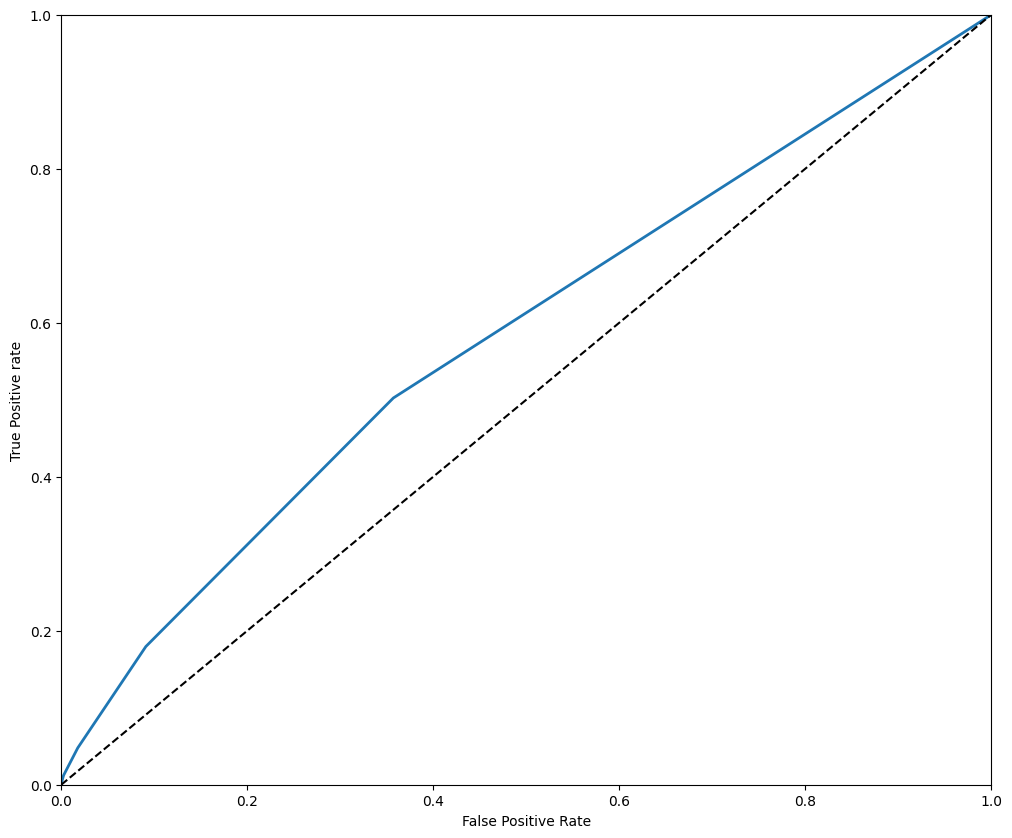

In [40]:
knn = KNeighborsClassifier(n_neighbors=9)
knn.fit(X_train, Y_train)

# Predictions for test data
knn_pred = knn.predict_proba(X_test)[:,1]
# Evalulate predictions
fpr, tpr, _ = roc_curve(Y_test, knn_pred)

knn_roc_auc = auc(fpr,tpr)
knn_cv_roc_auc = cross_val_score(knn, X_train, Y_train, scoring='roc_auc', cv=10).mean()

print ('Logistic Regression AUC Score :', knn_roc_auc)
print('Logistic Regression Cross Validation AUC Score :', knn_cv_roc_auc)
plot_roc_curve(fpr,tpr)

<h3> Random Forest Classifier </h3>

RandomForestClassifier AUC Score : 0.8536013296831525
RandomForestClassifier Cross Valication AUC Score : 0.8584547392821816


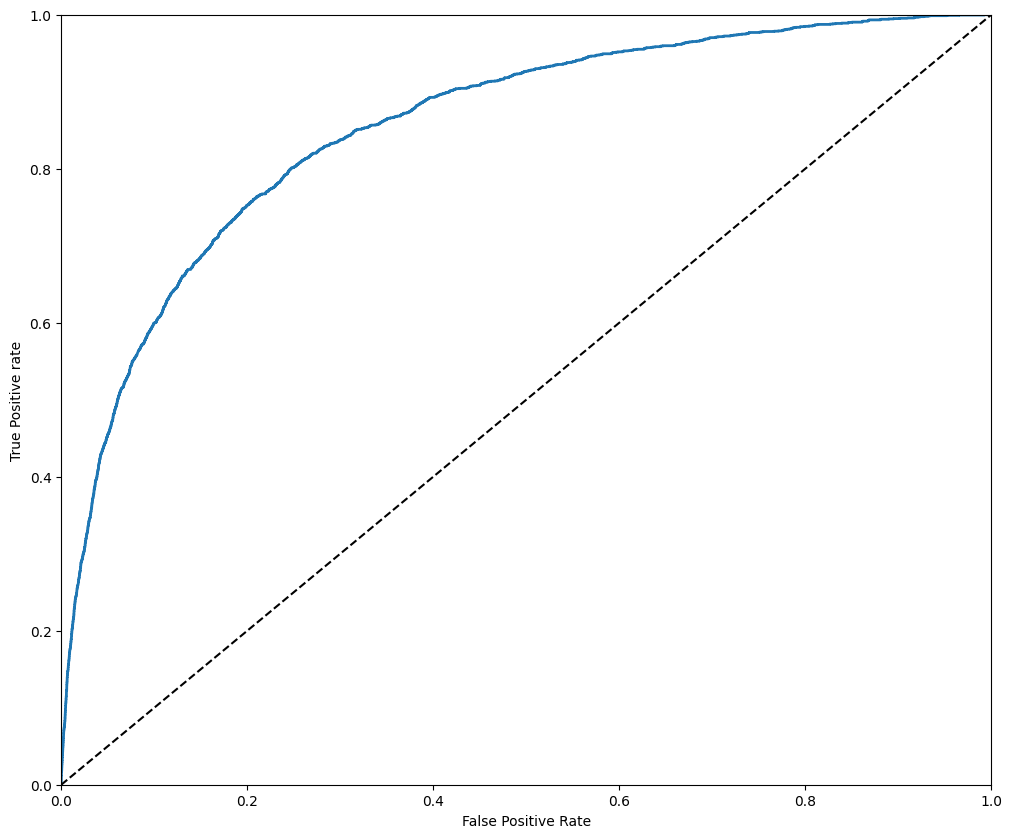

In [47]:
rfc = RandomForestClassifier(n_estimators=300, random_state=111, max_depth=5, class_weight='balanced')
rfc.fit(X_train, Y_train)

rfc_pred = rfc.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(Y_test, rfc_pred)

rfc_roc_auc = auc(fpr,tpr)
rfc_cv_roc_auc = cross_val_score(rfc, X_train, Y_train, scoring='roc_auc', cv=10).mean()

print ('RandomForestClassifier AUC Score :', rfc_roc_auc)
print('RandomForestClassifier Cross Valication AUC Score :', rfc_cv_roc_auc)
plot_roc_curve(fpr,tpr)

<h3> Gradient Boosting Classifier </h3>

GradientBoostingClassifier AUC Score : 0.8604604577173952
GradientBoostingClassifier CV AUC Score : 0.8642617301529821


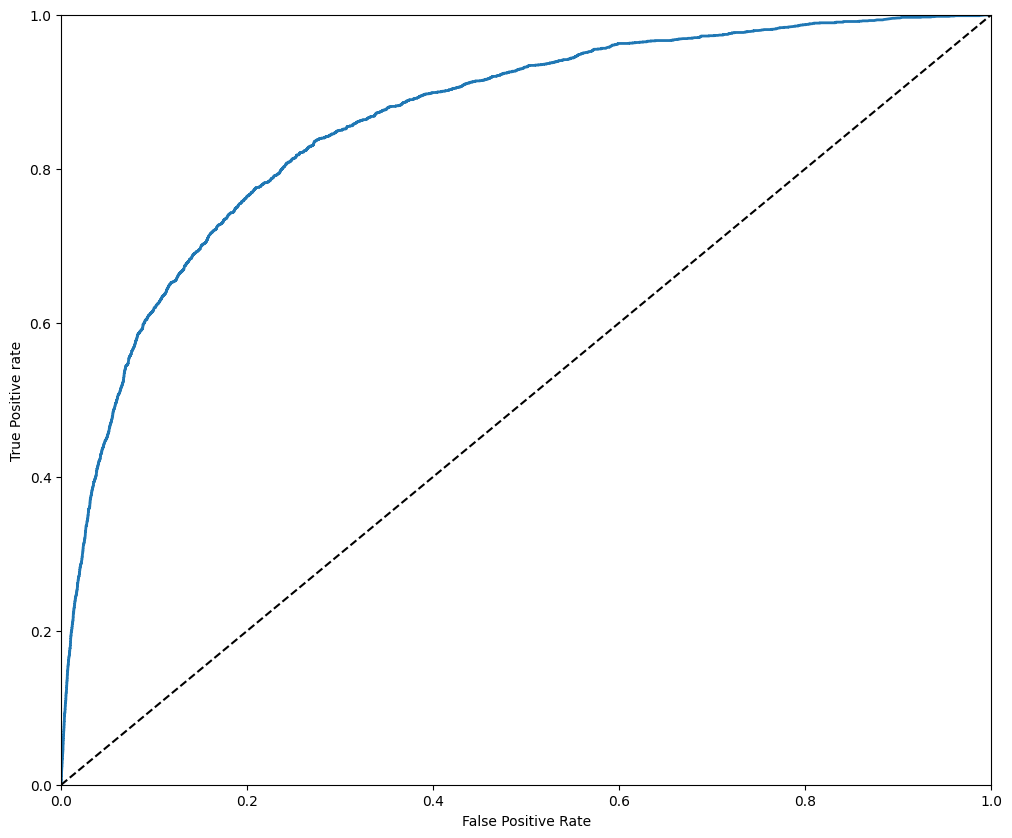

In [42]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train,Y_train)

gbc_pred = gbc.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test, gbc_pred)

gbc_roc_auc = auc(fpr,tpr)
gbc_cv_roc_auc = cross_val_score(gbc, X_train, Y_train, scoring='roc_auc', cv=10).mean()

print ('GradientBoostingClassifier AUC Score :', gbc_roc_auc)
print('GradientBoostingClassifier CV AUC Score :', gbc_cv_roc_auc)
plot_roc_curve(fpr,tpr)

<h3> XGBoost </h3>

XGBClassifier AUC Score : 0.8579678809159841
XGBClassifier CV AUC Score : 0.8609417199746099


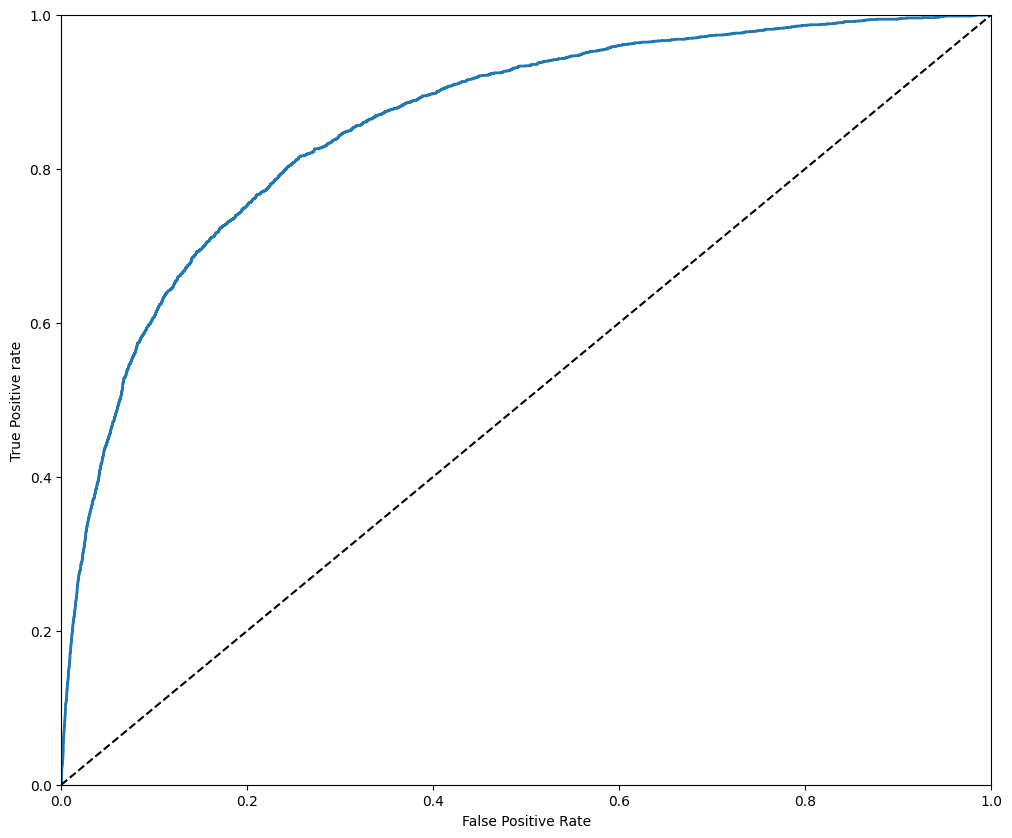

In [43]:
xgbc = XGBClassifier(max_depth=5,eval_metric='auc',objective='binary:logistic')
xgbc.fit(X_train, Y_train)

xgbc_pred = xgbc.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test, xgbc_pred)

xgbc_roc_auc = auc(fpr,tpr)
xgbc_cv_roc_auc = cross_val_score(xgbc, X_train, Y_train, scoring='roc_auc', cv=10).mean()

plot_roc_curve(fpr,tpr)
print ('XGBClassifier AUC Score :', xgbc_roc_auc)
print('XGBClassifier CV AUC Score :', xgbc_cv_roc_auc)

<h2> Conclusions </h2>

In [48]:
models_compare = pd.DataFrame({'Model': ['KNN', 'RandomForest', 'GradientBoosting', 'XGBoost'], 
                        'AUC' : [knn_roc_auc, rfc_roc_auc, gbc_roc_auc, xgbc_roc_auc], 
                        'Cross Val AUC' : [knn_cv_roc_auc, rfc_cv_roc_auc, gbc_cv_roc_auc, xgbc_cv_roc_auc]})
models_compare.sort_values(by='AUC', ascending=True)

,Model,AUC,Cross Val AUC
0,KNN,0.582436,0.585632
1,RandomForest,0.853601,0.858455
3,XGBoost,0.857968,0.860942
2,GradientBoosting,0.860460,0.864262


Comparing the AUC scores from the KNN, XGBoost, GradientBoosting and RandomForest models, it was found that the XGBoost and GradientBoosting models showed the highest accuracy for predicting the probability of financial distress in the next 2 years. <br><br>
Although GradientBoosting showed a higher AUC than XGBoost, the XGBoost model had a much faster performance time by 1m 15s, or 327%. For larger datasets, XGBoost would be more optimal as a prediction model.<br><br>
Since this competition is scored based on AUC, <b>GradientBoosting</b> will be used as the final model.

Final GradientBoostingClassifier AUC Score : 0.8609415962108329
Final GradientBoostingClassifier CV AUC Score : 0.8650125308238712


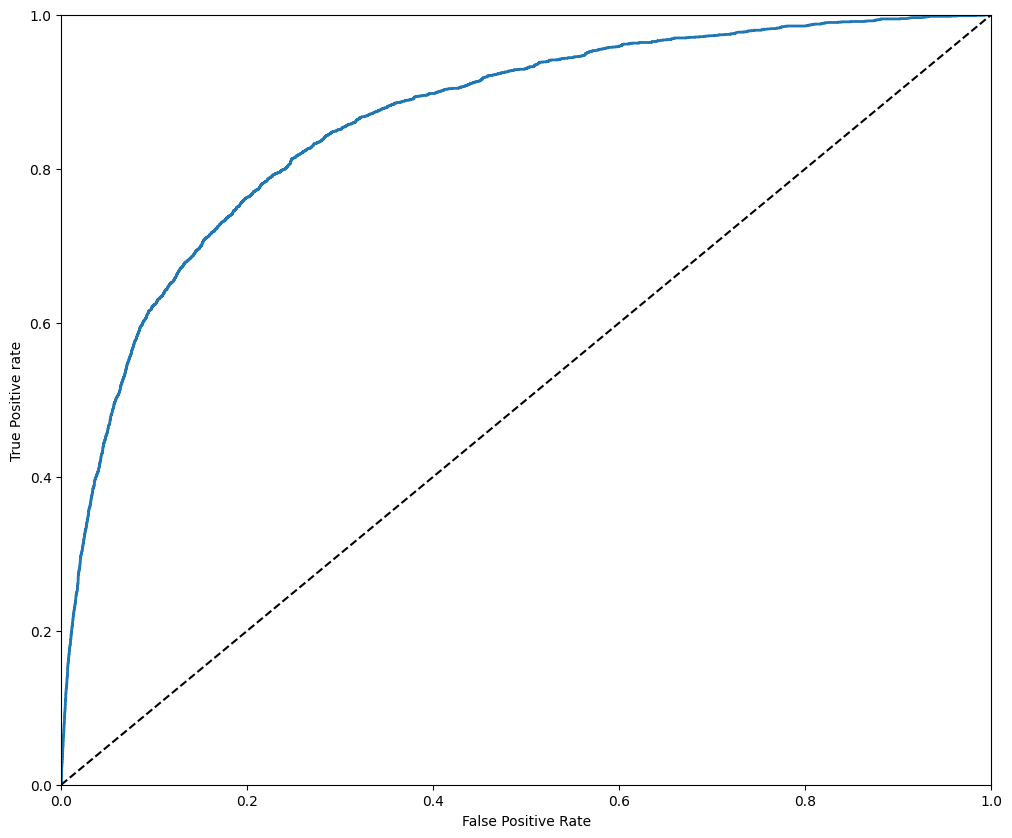

In [70]:
gbc_submission = GradientBoostingClassifier(n_estimators=200, learning_rate=0.05 ,max_depth=4,  random_state=42)
gbc_submission.fit(X_train,Y_train)

gbc_submission_pred = gbc_submission.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(Y_test, gbc_submission_pred)

gbc_submission_roc_auc = auc(fpr,tpr)
gbc_submission_cv_roc_auc = cross_val_score(gbc_submission, X_train, Y_train, scoring='roc_auc', cv=10).mean()

print ('Final GradientBoostingClassifier AUC Score :', gbc_submission_roc_auc)
print('Final GradientBoostingClassifier CV AUC Score :', gbc_submission_cv_roc_auc)
plot_roc_curve(fpr,tpr)

In [82]:
test['MonthlyIncome'].fillna(0, inplace=True)
test['NumberOfDependents'].fillna(0, inplace=True)

In [86]:
# Testing dataset used for evaluating our model
x = test.drop(['SeriousDlqin2yrs', 'ID'],axis=1)
y = gbc_submission.predict_proba(x)[:,1]

submission = pd.DataFrame({'ID': np.arange(1, len(x)+1), 'Probability': y})
submission.to_csv("submission.csv", index=False)
submission

,ID,Probability
0,1,0.068334
1,2,0.048459
2,3,0.012633
3,4,0.063163
4,5,0.089285
...,...,...
101498,101499,0.029230
101499,101500,0.318423
101500,101501,0.007963
101501,101502,0.048874
